In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import sys
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from embedding_layers import SkeletalInputEmbedding
from encoder_layers import TransformerEncoder
from decoder_layers import TransformerDecoder
import TF_helper_functions as hf
import pickle
import ipyvolume as ipv
import numpy as np
import ipywidgets as widgets
from IPython.display import display


In [2]:
datapath='/home/maleen/research_data/Transformers/datasets/training/'
# Base path and file information
base_name='24_07_25_training_norm'

weights_path='/home/maleen/research_data/Transformers/models/TF_tokenised/24_07_31_v1_best_model.pth'

filename=datapath+base_name+'.pkl'

def load_results_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def process_all_datasets(results, input_length=60, predict_length=60):
    all_X_pos, all_X_vel, all_X_acc = [], [], []
    all_Y_pos, all_Y_vel, all_Y_acc = [], [], []
    discarded_frames = {}

    for i in range(1, 7):  # Assuming you have 6 datasets
        dataset_key = f'dataset{i}'
        norm_pos = results[f'{dataset_key}_normpos']
        norm_vel = results[f'{dataset_key}_normvel']
        norm_acc = results[f'{dataset_key}_normacc']

        # Generate sequences for this dataset
        X_pos, X_vel, X_acc, Y_pos, Y_vel, Y_acc = hf.generate_sequences(norm_pos, norm_vel, norm_acc, input_length, predict_length)
        
        all_X_pos.append(X_pos)
        all_X_vel.append(X_vel)
        all_X_acc.append(X_acc)
        all_Y_pos.append(Y_pos)
        all_Y_vel.append(Y_vel)
        all_Y_acc.append(Y_acc)

        # Calculate discarded frames
        total_frames = norm_pos.shape[0]
        used_frames = X_pos.shape[0] + input_length + predict_length - 1
        discarded = total_frames - used_frames
        discarded_frames[dataset_key] = discarded

    # Combine sequences from all datasets
    combined_X_pos = np.concatenate(all_X_pos)
    combined_X_vel = np.concatenate(all_X_vel)
    combined_X_acc = np.concatenate(all_X_acc)
    combined_Y_pos = np.concatenate(all_Y_pos)
    combined_Y_vel = np.concatenate(all_Y_vel)
    combined_Y_acc = np.concatenate(all_Y_acc)

    return (combined_X_pos, combined_X_vel, combined_X_acc, 
            combined_Y_pos, combined_Y_vel, combined_Y_acc, 
            discarded_frames)


In [3]:
input_length = 30
predict_length = 2
datasetnum=6

# Load the results
results = load_results_from_pickle(filename)

# Process all datasets and get combined sequences
(combined_X_pos, combined_X_vel, combined_X_acc, 
 combined_Y_pos, combined_Y_vel, combined_Y_acc, 
 discarded_frames) = process_all_datasets(results, input_length, predict_length)

print("Combined sequences shapes:")
print(f"X_pos shape: {combined_X_pos.shape}")
print(f"X_vel shape: {combined_X_vel.shape}")
print(f"X_acc shape: {combined_X_acc.shape}")
print(f"Y_pos shape: {combined_Y_pos.shape}")
print(f"Y_vel shape: {combined_Y_vel.shape}")
print(f"Y_acc shape: {combined_Y_acc.shape}")

print("\nDiscarded frames per dataset:")
for dataset, frames in discarded_frames.items():
    print(f"{dataset}: {frames} frames")


Combined sequences shapes:
X_pos shape: (7667, 30, 6, 3)
X_vel shape: (7667, 30, 6, 3)
X_acc shape: (7667, 30, 6, 3)
Y_pos shape: (7667, 2, 6, 3)
Y_vel shape: (7667, 2, 6, 3)
Y_acc shape: (7667, 2, 6, 3)

Discarded frames per dataset:
dataset1: 0 frames
dataset2: 0 frames
dataset3: 0 frames
dataset4: 0 frames
dataset5: 0 frames
dataset6: 0 frames


Epoch [1/100], Loss: 0.2727
Saved new best model with validation loss: 0.2727
Epoch [2/100], Loss: 0.1716
Saved new best model with validation loss: 0.1716
Epoch [3/100], Loss: 0.1428
Saved new best model with validation loss: 0.1428
Epoch [4/100], Loss: 0.1322
Saved new best model with validation loss: 0.1322
Epoch [5/100], Loss: 0.1252
Saved new best model with validation loss: 0.1252
Epoch [6/100], Loss: 0.1211
Saved new best model with validation loss: 0.1211
Epoch [7/100], Loss: 0.1174
Saved new best model with validation loss: 0.1174
Epoch [8/100], Loss: 0.1143
Saved new best model with validation loss: 0.1143
Epoch [9/100], Loss: 0.1108
Saved new best model with validation loss: 0.1108
Epoch [10/100], Loss: 0.1084
Saved new best model with validation loss: 0.1084
Epoch [11/100], Loss: 0.1061
Saved new best model with validation loss: 0.1061
Epoch [12/100], Loss: 0.1034
Saved new best model with validation loss: 0.1034
Epoch [13/100], Loss: 0.1011
Saved new best model with valida

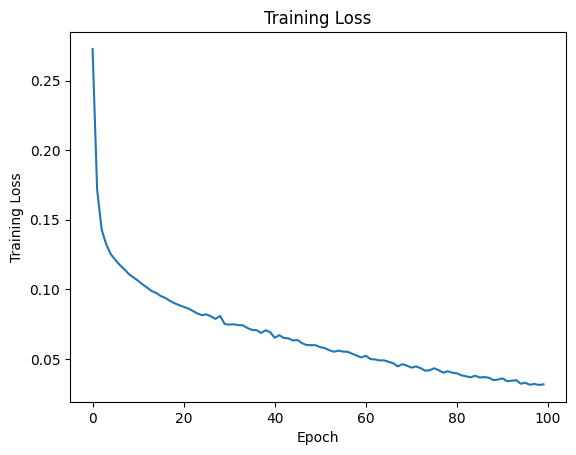

In [4]:
# Assuming you have already defined your models and set up your training loop
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")

# Initialize models
embed_dim = 128
num_heads = 8
num_layers = 6
num_joints = 6
dropout_rate = 0.1
dof=3
input_dim = num_joints * dof
batch_size = 1


start_token = torch.zeros(1, num_joints, 3).to(device)  # Assuming start token

# Assuming sequence length
# input_length = 30
# predict_length = 2


# tgt_mask= create_shifted_mask((input_length-1), num_joints)
# tgt_mask = tgt_mask.to(device)

# Convert to PyTorch tensors
X_pos_tensor = torch.tensor(combined_X_pos, dtype=torch.float32)
X_vel_tensor = torch.tensor(combined_X_vel, dtype=torch.float32)
X_acc_tensor = torch.tensor(combined_X_acc, dtype=torch.float32)

Y_pos_tensor = torch.tensor(combined_Y_pos, dtype=torch.float32)
Y_vel_tensor = torch.tensor(combined_Y_vel, dtype=torch.float32)
Y_acc_tensor = torch.tensor(combined_Y_acc, dtype=torch.float32)

# Create the full dataset
full_dataset = TensorDataset(X_pos_tensor, X_vel_tensor, X_acc_tensor, Y_pos_tensor, Y_vel_tensor, Y_acc_tensor)

# Data loader

train_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

#Defining Models
embedding = SkeletalInputEmbedding(input_dim).to(device)
encoder = TransformerEncoder(embed_dim, num_heads, num_layers, dropout_rate).to(device)
decoder = TransformerDecoder(embed_dim, num_heads, num_layers, num_joints, dropout_rate).to(device)

# Loss function
#criterion = nn.MSELoss()
criterion = hf.MaskedMSELoss()

# Optimizer
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.00001) #0.00001


# Training loop
num_epochs = 100
best_loss = float('inf')
train_losses = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0.0

    for batch in train_loader:
        # Unpack batch
        X_pos_batch, X_vel_batch, X_acc_batch, Y_pos_batch, Y_vel_batch, Y_acc_batch = batch

        # Memory Data
        X_pos_batch = X_pos_batch.to(device)
        X_vel_batch = X_vel_batch.to(device)
        X_acc_batch = X_acc_batch.to(device)

        inputembeddings = embedding(X_pos_batch, X_vel_batch)
       
        memory = encoder(inputembeddings, src_key_padding_mask=None)

        # Output Data
        Y_pos_batch = Y_pos_batch.to(device)
        Y_vel_batch = Y_vel_batch.to(device)
        Y_acc_batch = Y_acc_batch.to(device)

        #Target Data
        Y_pos_target=X_pos_batch[:, -1:, :, :]
        Y_vel_target=Y_vel_batch[:,:-1,:,:]
        Y_acc_target=Y_acc_batch[:,:-1,:,:]

        #Expected Data 
        
        Y_pos_expected=Y_pos_batch[:,1:,:,:]

        targetembeddings = embedding(Y_pos_target, Y_vel_target)

        # Perform forward pass through decoder
        output = decoder(targetembeddings, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None)

        output = output.where(~torch.isnan(output), torch.zeros_like(output))
        Y_pos_expected = Y_pos_expected.where(~torch.isnan(Y_pos_expected), torch.zeros_like(Y_pos_expected))

                
        # print("input embeddings: ", np.shape(inputembeddings))
        # print("memory: ", np.shape(memory))
        #print("target: ", np.shape(targetembeddings))
        #print("output: ", np.shape(output))
        # print("Expected output: ", np.shape(Y_pos_expected))
        # Compute loss
        loss = criterion(output, Y_pos_expected)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate total loss for the epoch
        total_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Print or log average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    # Save model weights if the current epoch has the best loss
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'embedding_state_dict': embedding.state_dict(),
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, weights_path)
        print(f'Saved new best model with validation loss: {avg_loss:.4f}')


# Plot training loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()
